# Solving differential equations with dCGP

Lets first import dcgpy and pyaudi and set up things as to use dCGP on gduals defined over floats

In [1]:
from dcgpy import expression_gdual_vdouble as expression
from dcgpy import kernel_set_gdual_vdouble as kernel_set
from pyaudi import gdual_vdouble as gdual
from matplotlib import pyplot as plt
import numpy as np
from numpy import sin, cos
from random import randint
np.seterr(all='ignore') # avoids numpy complaining about early on malformed expressions being evalkuated
%matplotlib inline

## 1 - We define the set of kernel functions we will be using

In [2]:
kernels = kernel_set(["sum", "mul", "div", "log", "sin", "cos", "exp"])() # note the call operator (returns the list of kernels)

## 2 - We instantiate a (1 in 1 out) dCGP and we inspect a randomly created program

In [3]:
dCGP_example = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = 1)

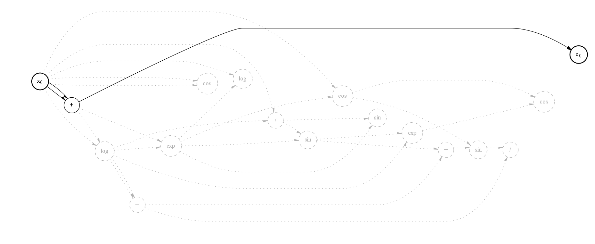

Represented expression:  (x+x)
Simplified expression:  [2*x]


In [4]:
plt.rcParams["figure.figsize"] = [10,6]
dCGP_example.visualize() #requires pygraphwiz module installed
print("Represented expression: ", dCGP_example(["x"])[0])
print("Simplified expression: ", dCGP_example.simplify(["x"])) #requires sympy module installed

# 3 - We define the ES that will evolve solutions

In [46]:
# We run an evolutionary strategy ES(1 + offspring)
def run_experiment(max_gen, offsprings, quadratic_error, initial_conditions_error, dCGP, screen_output=False):
    chromosome = [1] * offsprings
    fitness = [1] *offsprings
    best_chromosome = dCGP.get()
    best_fitness = quadratic_error(dCGP, grid) + initial_conditions_error(dCGP)
    for g in range(max_gen):
        for i in range(offsprings):
            dCGP.set(best_chromosome)
            dCGP.mutate_active(i) #  we mutate a number of increasingly higher active genes
            qe = quadratic_error(dCGP, grid)
            ie = initial_conditions_error(dCGP)
            fitness[i] = ie + qe
            chromosome[i] = dCGP.get()
        for i in range(offsprings):
            if fitness[i] <= best_fitness:
                if (fitness[i] != best_fitness) and screen_output:
                    print("New best found: gen: ", g, " value: ", fitness[i])
                best_chromosome = chromosome[i]
                best_fitness = fitness[i]
                dCGP.set(best_chromosome)
        if best_fitness < 1e-7:
            break
    return g, best_chromosome

## 4 - We consider the following Ordinary Differential Equation (ODE1):

$\frac{dy}{dx} = \frac{2x - y}{x}$, with $y(0.1) = 20.1$ and $x \in [0.1,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

The solution to the ODE is $y = x + \frac 2x$

In [47]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE1(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    x = np.array(grid.constant_cf)
    ode1 = (2. * x - y) / x
    retval += (ode1 - dydx) * (ode1 - dydx)
    return sum(retval)

In [48]:
# We define a penalty term associated to the initial conditions violation
def ic_ODE1(dCGP):
    x0 = 1
    y0 = 3
    out = dCGP([gdual([x0])])[0]
    return (out.constant_cf[0] - y0) * (out.constant_cf[0] - y0)

In [49]:
# We construct the grid of points. Since the ODE only contains first order derivatives we use truncation order 1.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0.1,1,10)
grid = gdual(values, "x", 1)

In [51]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
offsprings = 10
stop = 400
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_ODE1, initial_conditions_error=ic_ODE1, dCGP = dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
0 		 278 	 ['(x+((((x/x)/x)/(x/x))+((x/x)/x)))']  a.k.a  [x + 2/x]
1 		 307 	 ['(((x+x)/(x*x))+x)']  a.k.a  [x + 2/x]
2 		 277 	 ['(((x/(x*x))+x)+(x/(x*x)))']  a.k.a  [x + 2/x]
6 		 323 	 ['(((x/(x*x))+x)+(x/(x*x)))']  a.k.a  [x + 2/x]
9 		 62 	 ['(x+(((x/x)+(x/x))/x))']  a.k.a  [x + 2/x]
16 		 271 	 ['((x/(x*x))+(x+(x/(x*x))))']  a.k.a  [x + 2/x]
19 		 225 	 ['((((x/x)/x)+((x/x)/x))+x)']  a.k.a  [x + 2/x]
22 		 288 	 ['((((x/x)+(x/x))/x)+x)']  a.k.a  [x + 2/x]
29 		 358 	 ['(x+((x+x)/(x*x)))']  a.k.a  [x + 2/x]
30 		 129 	 ['(x+(((x/x)+(x/x))/x))']  a.k.a  [x + 2/x]
34 		 179 	 ['(((((x+x)+(x+x))/x)/(x+x))+x)']  a.k.a  [x + 2/x]
35 		 146 	 ['(((x+x)/(x*x))+x)']  a.k.a  [x + 2/x]
37 		 364 	 ['(x+(((x+x)/x)/exp(log(x))))']  a.k.a  [x + 2/x]
39 		 21 	 ['((((sin(x)/sin(x))+(sin(x)/sin(x)))/x)+x)']  a.k.a  [x + 2/x]
40 		 175 	 ['((((x/x)*x)+((x/x)/x))+((x/x)*((x/x)/x)))']  a.k.a  [x + 2/x]
48 		 189 	 ['((((x/x)/x)+((x/x)/x))+x)']  a.k.a  [x + 2/x]
49 		 9

In [11]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 653 * 200)

ERT Expected run time - avg. number of function evaluations needed:  9822.35294118
Avg. number of function evaluations from Tsoulos paper:  130600


## 5 - We consider the following Ordinary Differential Equation (ODE2):

$\frac{dy}{dx} = \frac{1 - ycos(x)}{sin(x)}$, with $y(0.1) = \frac{2.1}{sin(0,1)}$ and $x \in [0.1,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = \frac{x+2}{sin(x)}$

In [52]:
# We construct the grid of points. Since the ODE only contains first order derivatives we use truncation order 1.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0.1,1,10)
grid = gdual(values, "x", 1)

In [53]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE2(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    x = np.array(grid.constant_cf)
    ode2 = (1. -  y * cos(x)) / sin(x)
    retval += (ode2 - dydx) * (ode2 - dydx)
    return sum(retval)

In [54]:
# We define a penalty term associated to the initial conditions violation
dummy = (2.1)/sin(0.1)
def ic_ODE2(dCGP):
    x0 = 0.1
    y0 = dummy
    out = dCGP([gdual([x0])])[0]
    return (out.constant_cf[0] - y0) * (out.constant_cf[0] - y0)

In [56]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 400
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_ODE2, initial_conditions_error=ic_ODE2, dCGP=dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
0 		 85 	 ['((((exp(x)/exp(x))+x)+(exp(x)/exp(x)))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
16 		 251 	 ['((x/sin(x))+(((x/sin(x))+(x/sin(x)))/x))']  a.k.a  [x/sin(x) + 2/sin(x)]
23 		 314 	 ['((((x/x)+(x/x))+x)/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
26 		 324 	 ['((((x/x)+x)+(x/x))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
28 		 124 	 ['((((x/x)+(x*(x/x)))+(x/x))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
36 		 50 	 ['(((x/(x/x))+((x/x)+(x/x)))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
44 		 110 	 ['((x+((x+x)/x))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
54 		 230 	 ['(((x/x)+((x+(x/x))/(x/x)))/sin(exp(log(x))))']  a.k.a  [x/sin(x) + 2/sin(x)]
55 		 70 	 ['((x/sin(x))+(((x/sin(x))+(x/sin(x)))/(sin(x)*(x/sin(x)))))']  a.k.a  [x/sin(x) + 2/sin(x)]
62 		 188 	 ['((((x/sin(x))/x)+(x/sin(x)))+((x/sin(x))/x))']  a.k.a  [x/sin(x) + 2/sin(x)]
65 		 248 	 ['((x/sin(x))+log(exp((((x/x)+(x/x))/sin(x)))))']  a.k.a  [x/sin(x) + 2/sin(x)]
70 		 106 	 ['(((x*(x/x))+log((exp((x/

In [17]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 742 * 200)

ERT Expected run time - avg. number of function evaluations needed:  37556.0
Avg. number of function evaluations from Tsoulos paper:  148400


## 6 - We consider the following Ordinary Differential Equation (ODE5):

$\frac{d^2y}{dx^2} = 6\frac{dy}{dx} - 9y$, with $y(0) = 0$, $\frac{dy}{dx}(0)=2$ and $x \in [0,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = 2x \exp(3x)$

In [61]:
# We construct the grid of points. Since the ODE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0,1,10)
grid = gdual(values, "x", 2)

In [62]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE5(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    dydx2 = np.array(out.get_derivative({"dx" : 2}))
    x = np.array(grid.constant_cf)
    ode5 = 6. * dydx - 9 * y
    retval += (ode5 - dydx2) * (ode5 - dydx2)
    return sum(retval)

In [63]:
# We define a penalty term associated to the initial conditions violation
def ic_ODE5(dCGP):
    x0 = 1e-16 # avoids what seems a numerical problem with vectorized dual?
    y0 = 0.
    dy0 = 2.
    out = dCGP([gdual([x0], "x", 1)])[0]
    dCGP_y0 = out.constant_cf[0]
    dCGP_dy0 = out.get_derivative({"dx" : 1})[0]
    return (dCGP_y0 - y0) * (dCGP_y0 - y0) + (dCGP_dy0 - dy0) * (dCGP_dy0 - dy0)

In [64]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 400
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_ODE5, initial_conditions_error=ic_ODE5, dCGP=dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
9 		 221 	 ['((exp(x)*(exp(x)*exp(x)))*log((exp(x)*exp(x))))']  a.k.a  [2*x*exp(3*x)]
11 		 221 	 ['(log((exp(x)*exp(x)))*(exp(x)*(exp(x)*exp(x))))']  a.k.a  [2*x*exp(3*x)]
12 		 145 	 ['(exp(x)*((x+x)*exp((x+x))))']  a.k.a  [2*x*exp(3*x)]
29 		 383 	 ['((x+x)*exp((x+(x+x))))']  a.k.a  [2*x*exp(3*x)]
32 		 106 	 ['((x+x)*exp(((x+x)+x)))']  a.k.a  [2*x*exp(3*x)]
33 		 371 	 ['(exp(((x+x)+x))*(x+x))']  a.k.a  [2*x*exp(3*x)]
35 		 241 	 ['((exp(x)*((exp(x)*exp(x))+(exp(x)*exp(x))))*log(exp(x)))']  a.k.a  [2*x*exp(3*x)]
39 		 211 	 ['(exp(x)*(exp((x+x))*(x+x)))']  a.k.a  [2*x*exp(3*x)]
66 		 270 	 ['(exp(x)*(((x+x)*exp(x))*exp(x)))']  a.k.a  [2*x*exp(3*x)]
67 		 84 	 ['((exp(x)*exp((x+x)))*(x+x))']  a.k.a  [2*x*exp(3*x)]
68 		 184 	 ['((x*(exp(x)*exp(x)))*(exp(x)+exp(x)))']  a.k.a  [2*x*exp(3*x)]
70 		 393 	 ['((exp(x)*((exp(x)+exp(x))*x))*exp(x))']  a.k.a  [2*x*exp(3*x)]
72 		 395 	 ['((exp((x+x))*exp(x))*(x+x))']  a.k.a  [2*x*exp(3*x)]
78 		 250 	 ['(exp((x+

In [65]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 441 * 200)

ERT Expected run time - avg. number of function evaluations needed:  24938.6666667
Avg. number of function evaluations from Tsoulos paper:  88200


## 7 - We consider the following non linear Ordinary Differential Equation (NLODE3):

$\frac{d^2y}{dx^2}\frac{dy}{dx} = -\frac4{x^3}$, with $y(1) = 0$, and $x \in [1,2]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = log(x^2)$

In [66]:
# We construct the grid of points. Since the ODE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(1,2,10)
grid = gdual(values, "x", 2)

In [67]:
# We define the quadratic error of the dCGP in the grid points
def qe_NLODE3(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    dydx2 = np.array(out.get_derivative({"dx" : 2}))
    x = np.array(grid.constant_cf)
    nlode3 = dydx2*dydx
    retval += (nlode3 + 4/x/x/x) * (nlode3 + 4/x/x/x)
    return sum(retval)

In [68]:
# We define a penalty term associated to the initial conditions violation
def ic_NLODE3(dCGP):
    x0 = 1.
    y0 = 0.
    out = dCGP([gdual([x0])])[0]
    dCGP_y0 = out.constant_cf[0]
    dCGP_dy0 = out.get_derivative({"dx" : 1})[0]
    return (dCGP_y0 - y0) * (dCGP_y0 - y0)

In [69]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 400
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_NLODE3, initial_conditions_error=ic_NLODE3, dCGP=dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
0 		 22 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
1 		 18 	 ['(log((x*(x/x)))+log((x*(x/x))))']  a.k.a  [2*log(x)]
2 		 16 	 ['log((x*x))']  a.k.a  [log(x**2)]
3 		 27 	 ['log((x*x))']  a.k.a  [log(x**2)]
5 		 23 	 ['log(log(exp((x*x))))']  a.k.a  [log(x**2)]
6 		 23 	 ['log((x*x))']  a.k.a  [log(x**2)]
7 		 9 	 ['log((x*x))']  a.k.a  [log(x**2)]
8 		 5 	 ['log((x*x))']  a.k.a  [log(x**2)]
9 		 8 	 ['log((x*x))']  a.k.a  [log(x**2)]
10 		 8 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
11 		 0 	 ['log((x*x))']  a.k.a  [log(x**2)]
13 		 79 	 ['log(((x*x)/(sin(x)/sin(x))))']  a.k.a  [log(x**2)]
14 		 12 	 ['log((x*x))']  a.k.a  [log(x**2)]
15 		 0 	 ['log((x*x))']  a.k.a  [log(x**2)]
16 		 15 	 ['log((x*x))']  a.k.a  [log(x**2)]
17 		 1 	 ['log((((x+(x*x))/(x+(x*x)))/(x*x)))']  a.k.a  [log(x**(-2))]
18 		 8 	 ['log((x*x))']  a.k.a  [log(x**2)]
19 		 29 	 ['log(((x/x)/((x*x)/(x/x))))']  a.k.a  [log(x**(-2))]
21 		 34 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
22 		 1

In [29]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 191 * 200)

ERT Expected run time - avg. number of function evaluations needed:  540.97826087
Avg. number of function evaluations from Tsoulos paper:  38200


## 8 - We consider the following non linear Patial Differential Equation (PDE2):

$\nabla^2 \psi(x,y) = -\psi(x,y)$ with $x\in[0,1]$, $y\in[0,1]$ and boundary conditions: $\psi(0,y) = 0$, $\psi(1,y) = \sin(1)\cos(y)$

we demand its punctual validity over a squared grid of $N$ equally spaced points.

NOTE: The solution to the PDE is $\psi(x,y) = \sin(x)\cos(y)$

In [71]:
# We construct the grid of points. Since the PDE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual
N=10
values = np.linspace(0,1,N)
xval = np.append(values,[values]*(N-1))
yval = values.repeat(N)
grid = [gdual(xval, "x", 2), gdual(yval, "y", 2)]

In [72]:
# We define the quadratic error of the dCGP in the grid points
def qe_PDE1(dCGP, grid):
    retval = 0
    out = dCGP([grid[0], grid[1]])[0]
    psi = np.array(out.constant_cf)
    dpsidx2 = np.array(out.get_derivative({"dx" : 2}))
    dpsidy2 = np.array(out.get_derivative({"dy" : 2}))
    x = np.array(grid[0].constant_cf)
    y = np.array(grid[1].constant_cf)  
    pde1 = -2 * psi
    retval += (pde1 - dpsidx2 - dpsidy2) * (pde1 - dpsidx2 - dpsidy2)
    return sum(retval)

In [73]:
# We define a penalty term associated to the initial conditions violation
sin1 = np.sin(1)
def ic_PDE1(dCGP):
    x0 = gdual([0]*N)
    y0 = gdual(values)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = np.array(psi.constant_cf)
    err1 = (dCGP_psi - 0.) * (dCGP_psi - 0.)
    x0 = gdual([1]*N)
    y0 = gdual(values)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = psi.constant_cf
    err2 = (dCGP_psi - sin1*np.cos(values)) * (dCGP_psi - sin1*np.cos(values))
    return sum(err1) + sum(err2)

In [74]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 500
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=2, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_PDE1, initial_conditions_error=ic_PDE1, screen_output=False, dCGP=dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x","y"]), " a.k.a ", dCGP.simplify(["x","y"]))
res = np.array(res)

restart: 	 gen: 	 expression:
5 		 112 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
7 		 96 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
11 		 94 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
12 		 257 	 ['(cos(y)*sin(log(exp(x))))']  a.k.a  [sin(x)*cos(y)]
13 		 27 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
15 		 62 	 ['((cos(y)*(cos(y)/cos(y)))*sin(x))']  a.k.a  [sin(x)*cos(y)]
17 		 102 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
26 		 266 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
32 		 428 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
33 		 188 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
35 		 68 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
40 		 40 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
41 		 79 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
46 		 19 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
50 		 489 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
55 		 8 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
56 		 11 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
63 

In [35]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected Run Time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 203 * 200)

ERT Expected Run Time - avg. number of function evaluations needed:  10833.8235294
Avg. number of function evaluations from Tsoulos paper:  40600


## 9 - We consider the following non linear Patial Differential Equation (PDE6):

$\nabla^2 \psi(x,y) + \exp(\psi(x,y)) = 1 + x^2 + y^2 + \frac 4{(1 + x^2 + y^2)^2}$ with $x\in[0,1]$, $y\in[0,1]$ and boundary conditions: $\psi(0,y) = \log(1+y^2)$, $\psi(1,y) = \log(2+y^2)$

we demand its punctual validity over a squared grid of $N$ equally spaced points.

NOTE: The solution to the PDE is $\psi(x,y) = \log(1 + x^2 + y^2)$

In [76]:
# We construct the grid of points. Since the PDE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual
N=10
values = np.linspace(0.1,3.5,N)
xval = np.append(values,[values]*(N-1))
yval = values.repeat(N)
grid = [gdual(xval, "x", 2), gdual(yval, "y", 2)]

In [77]:
# We define the quadratic error of the dCGP in the grid points
def qe_PDE6(dCGP, grid):
    retval = 0
    out = dCGP([grid[0], grid[1]])[0]
    psi = np.array(out.constant_cf)
    dpsidx2 = np.array(out.get_derivative({"dx" : 2}))
    dpsidy2 = np.array(out.get_derivative({"dy" : 2}))
    x = np.array(grid[0].constant_cf)
    y = np.array(grid[1].constant_cf)  
    pde6 = 4./(1+x*x+y*y)**2
    retval += (pde6 - dpsidx2 - dpsidy2) * (pde6 - dpsidx2 - dpsidy2)
    return sum(retval) / N**2

In [87]:
# We define a penalty term associated to the initial conditions violation
def ic_PDE6(dCGP):
    x0 = gdual([0.1]*N)
    y0 = gdual(values)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = np.array(psi.constant_cf)
    err1 = (dCGP_psi - np.log(1+values*values+0.01)) * (dCGP_psi - np.log(1+values*values+0.01))
    x0 = gdual([1]*N)
    y0 = gdual(values)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = psi.constant_cf
    err2 = (dCGP_psi - np.log(2+values*values)) * (dCGP_psi - np.log(2+values*values))
    x0 = gdual(values)
    y0 = gdual([0.1]*N)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = np.array(psi.constant_cf)
    err3 = (dCGP_psi - np.log(1+values*values+0.01)) * (dCGP_psi - np.log(1+values*values+0.01))
    x0 = gdual(values)
    y0 = gdual([1]*N)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = psi.constant_cf
    err4 = (dCGP_psi - np.log(2+values*values)) * (dCGP_psi - np.log(2+values*values))
    return (sum(err1) + sum(err2) + sum(err4) + sum(err3)) 

In [ ]:
# We run nexp experiments to accumulate statistic for the ERT
kernels = kernel_set(["sum", "mul", "div", "log", "sin"])() # note the call operator (returns the list of kernels)
nexp = 100
stop = 500
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=2, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_PDE6, initial_conditions_error=ic_PDE6, screen_output=False, dCGP=dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x","y"]), " a.k.a ", dCGP.simplify(["x","y"]), " ", qe_PDE6(dCGP,grid)+ic_PDE6(dCGP))
res = np.array(res)

restart: 	 gen: 	 expression:
15 		 430 	 ['log(((y*y)+((x*x)+((y*x)/(y*x)))))']  a.k.a  [log(x**2 + y**2 + 1)]   8.00654045939e-29
26 		 184 	 ['log(((((y*y)/(y*y))+(y*y))+(x*x)))']  a.k.a  [log(x**2 + y**2 + 1)]   1.81207060071e-28


[log(x**2 + y**2 + 1)]


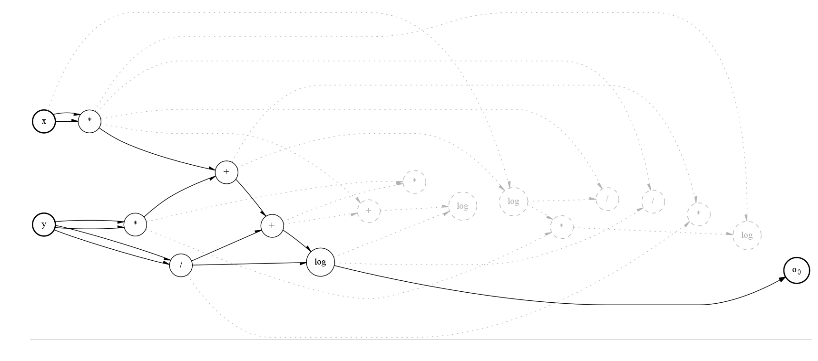

In [229]:
plt.rcParams["figure.figsize"] = [14,14]
x = [1, 0, 0, 1, 1, 1, 2, 1, 1, 0, 2, 3, 0, 4, 5, 3, 6, 4, 0, 2, 6, 1, 6, 3, 3, 8, 7, 3, 0, 5, 1, 3, 11, 2, 11, 2, 2, 7, 2, 1, 5, 4, 3, 12, 2, 7]
x = dCGP.set(x)
print(dCGP.simplify(["x", "y"]))
dCGP.visualize(["x", "y"])


In [240]:
ic_PDE6(dCGP)

1.2836323079340928e-32

In [230]:
dCGP([gdual([1]),gdual([0])])

[0]

In [222]:
np.log(2)

0.69314718055994529

In [83]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected Run Time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 797 * 200)

ERT Expected Run Time - avg. number of function evaluations needed:  55180.6666667
Avg. number of function evaluations from Tsoulos paper:  159400


In [30]:
dCGP

d-CGP Expression:
	Number of inputs:		1
	Number of outputs:		1
	Number of rows:			1
	Number of columns:		15
	Number of levels-back allowed:	16
	Basis function arity:		2

	Resulting lower bounds:	[0, 0, 0, 0, 0, ... ]
	Resulting upper bounds:	[6, 0, 0, 6, 1, ... ]

	Current expression (encoded):	[4, 0, 0, 1, 0, ... ]
	Active nodes:			[0, 1, 2, 3, 7, ... ]
	Active genes:			[0, 1, 2, 3, 4, ... ]

	Function set:			[sum, mul, div, log, sin, ... ]